# Lakeview logo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
from matplotlib import font_manager
import lakeview as lv

In [2]:
font_files = font_manager.findSystemFonts(fontpaths="fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
def gradient_fill(ax, x, y, fill_color=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    
    Adapted from https://stackoverflow.com/a/29331211/5958148

    Parameters
    ----------
    ax : a matplotlib Axes instance
        The axes to plot on.
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

In [4]:
CHROMOSOME = "17"
ILLUMINA_BAM_PATH = "../../tests/data/SKBR3_Illumina_550bp_pcrFREE.bam"

painter = lv.SequenceAlignment.from_file(
    ILLUMINA_BAM_PATH, region=CHROMOSOME
)

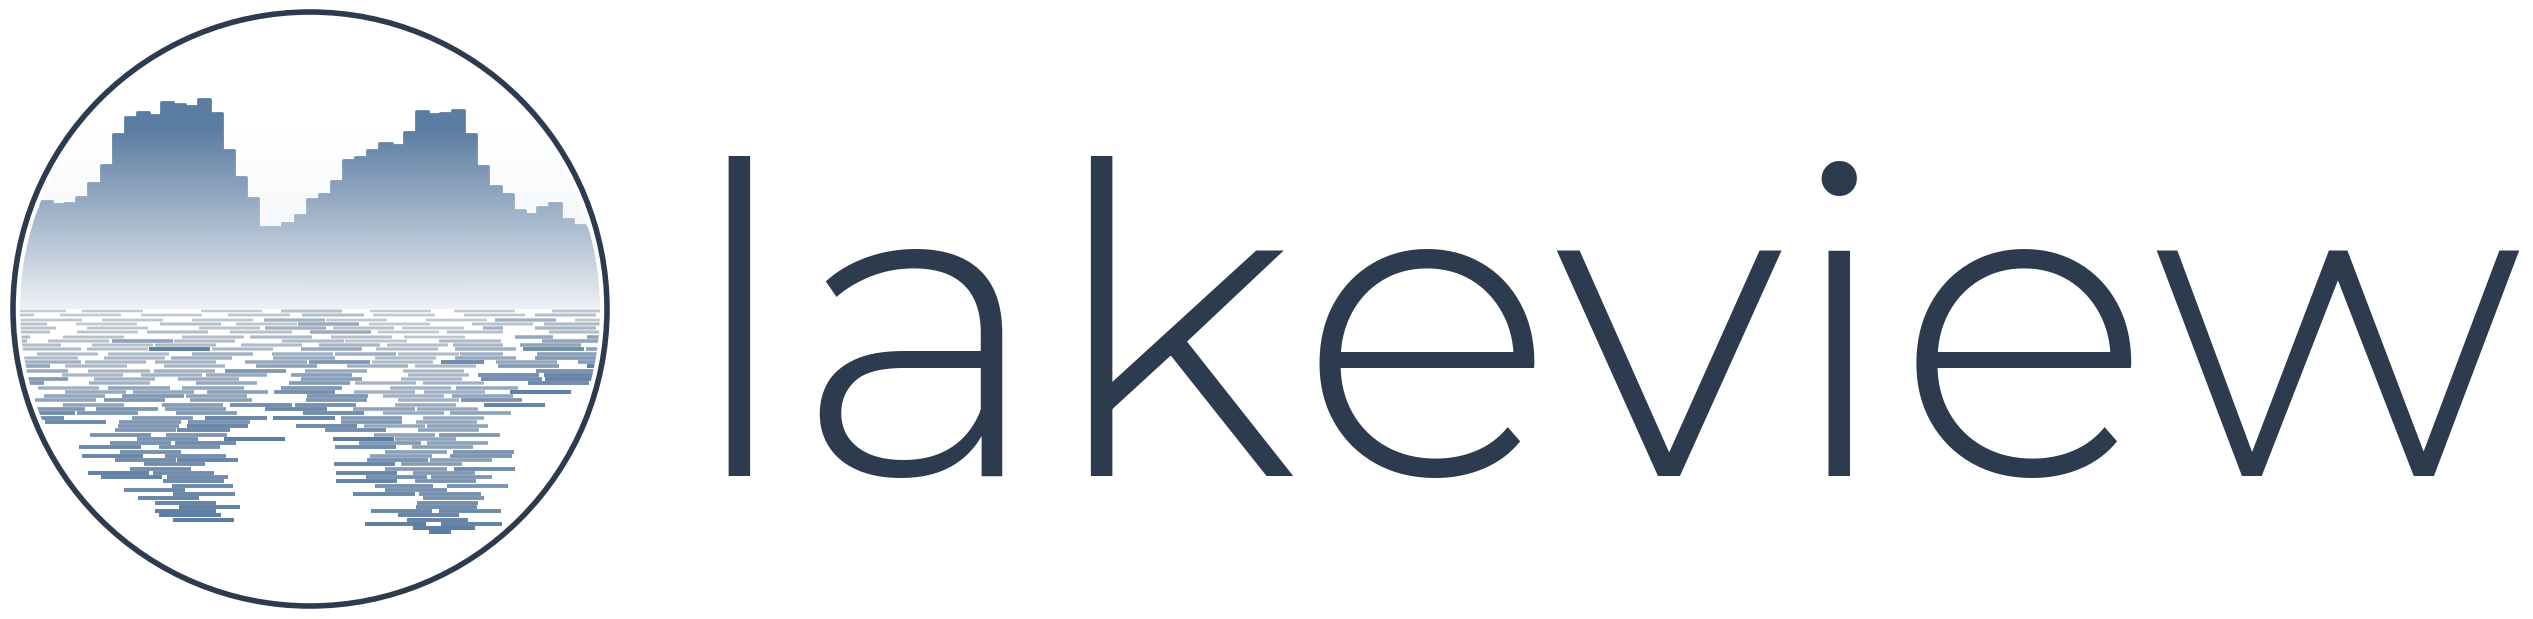

In [6]:
# Colors
SKY_COLOR = "w"
LAKE_COLOR = "w"
SEGMENT_COLOR = (92 / 255, 125 / 255, 162 / 255)
PILEUP_FACECOLOR = SEGMENT_COLOR
PILEUP_EDGECOLOR = PILEUP_FACECOLOR
FONT_COLOR = (44 / 255, 59 / 255, 77 / 255)

xlim = (6.404e7 + 2950, 6.404e7 + 3940)
rng = np.random.default_rng(4)

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_axes((0, 0.5, 1, 0.5))
ax4 = ax1.twinx()

ax1.set_facecolor(SKY_COLOR)
ax2 = fig.add_axes((0, 0, 1, 0.5))

ax2.set_facecolor(LAKE_COLOR)
ax3 = fig.add_axes((0, 0, 1, 1))

# Pileup
painter.draw_pileup(
    ax1,
    window_size=20,
    show_mismatches=False,
    pileup_kw=dict(
        facecolor=PILEUP_FACECOLOR,
        edgecolor=PILEUP_EDGECOLOR,
        linewidth=2,
        alpha=1,
    ),
)

n_segments = len(painter.segments)
segment_alpha = 1 - 0.9 * rng.random(n_segments)
segment_alpha = list(segment_alpha)
segment_colors = [(92 / 255, 125 / 255, 162 / 255, alpha) for alpha in segment_alpha]

# Alignment
painter.draw_alignment(
    ax2,
    sort_by=segment_alpha,
    filter_by=lambda __: rng.random() < 0.5,
    color_by=segment_colors,
    show_arrowheads=False,
    show_mismatches=False,
    show_insertions=False,
    show_deletions=False,
    show_soft_clippings=False,
    show_hard_clippings=False,
    height=2.9,
    min_spacing=0,
)

# Circles
circle1 = plt.Circle(
    (0.5, 0.5),
    radius=0.495,
    transform=ax3.transAxes,
    ec=FONT_COLOR,
    fc="none",
    zorder=1,
    lw=4,
)
circle2 = plt.Circle(
    (0.5, 0.5),
    radius=0.65,
    transform=ax3.transAxes,
    ec="w",
    fc="none",
    lw=144,
    zorder=0,
)
ax3.add_patch(circle1)
ax3.add_patch(circle2)

h = 0.35
rect1 = plt.Rectangle((0, 0.5 - h), width=1, height=2 * h, ec="k", fc="none")

ax1.set_xlim(xlim)
ymax = 102
ax1.set_ylim(0, ymax)

ax2.set_xlim(xlim)
ax2.set_ylim(70, -0.5)

for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ("top", "right", "bottom", "left"):
        ax.spines[spine].set_visible(False)
ax3.axis("off")

# Gradient
x = np.array([xlim[0]-10000, xlim[0]-10000, xlim[1]+10000, xlim[1]+10000])
GRADIENT_HEIGHT = 0.6
y = np.array([1 - GRADIENT_HEIGHT, 1, 1, 1 - GRADIENT_HEIGHT])
gradient_fill(ax4, x, y, fill_color=tuple(x/255 for x in (239, 242, 246)), zorder=2)

ax4.set_xlim(xlim)
ax4.set_ylim(1, 0)
ax4.axis("off")

# Text
ax5 = fig.add_axes((0, 0, 1, 1))
ax5.axis("off")
ax5.text(
    1.12,
    0.42,
    "lakeview",
    ha="left",
    va="center",
    size=310,
    fontname="Montserrat",
    color=FONT_COLOR,
)
fig.savefig("output/logo.svg", bbox_inches='tight', facecolor='w')